In [11]:
import pandas as pd
from datetime import timedelta

def preprocess_flight_data_remove_empty_dates(df):
    # Step 1: Remove rows where FL_DATE is missing or empty
    df = df[df['FL_DATE'].notna() & (df['FL_DATE'] != '')].copy()

    # Explicitly parse FL_DATE with correct format (MM/DD/YYYY)
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

    # Remove rows where parsing FL_DATE failed (NaT)
    df = df[df['FL_DATE'].notna()]

    # Filter for JFK flights (origin or destination)
    jfk_df = df[(df['ORIGIN'] == 'JFK') | (df['DEST'] == 'JFK')].copy()

    # Convert HHMM integer times to timedelta
    def hhmm_to_timedelta(x):
        if pd.isna(x):
            return pd.NaT
        x = int(x)
        hour = x // 100
        minute = x % 100
        return timedelta(hours=hour, minutes=minute)

    time_cols = ['CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME']
    for col in time_cols:
        jfk_df[col + '_DT'] = jfk_df[col].apply(hhmm_to_timedelta)

    # Create full timestamps for scheduled and actual departure
    jfk_df['CRS_DEP_TIMESTAMP'] = jfk_df['FL_DATE'] + jfk_df['CRS_DEP_TIME_DT']
    jfk_df['DEP_TIMESTAMP'] = jfk_df['FL_DATE'] + jfk_df['DEP_TIME_DT']

    # Adjust arrival date for overnight flights
    def adjust_arrival_date(row):
        arr_time = row['CRS_ARR_TIME_DT']
        dep_time = row['CRS_DEP_TIME_DT']
        arr_date = row['FL_DATE']
        if pd.isna(arr_time) or pd.isna(dep_time):
            return arr_date
        if arr_time < dep_time:
            arr_date += timedelta(days=1)
        return arr_date

    jfk_df['ARR_DATE_ADJUSTED'] = jfk_df.apply(adjust_arrival_date, axis=1)
    jfk_df['CRS_ARR_TIMESTAMP'] = jfk_df['ARR_DATE_ADJUSTED'] + jfk_df['CRS_ARR_TIME_DT']
    jfk_df['ARR_TIMESTAMP'] = jfk_df['ARR_DATE_ADJUSTED'] + jfk_df['ARR_TIME_DT']

    # Extract hours and day of week
    jfk_df['DEP_HOUR'] = jfk_df['CRS_DEP_TIMESTAMP'].dt.hour
    jfk_df['ARR_HOUR'] = jfk_df['CRS_ARR_TIMESTAMP'].dt.hour
    jfk_df['DAY_OF_WEEK'] = jfk_df['FL_DATE'].dt.day_name()

    # Convert delay columns to numeric and fill missing with 0
    delay_cols = ['DEP_DELAY', 'DEP_DELAY_NEW', 'ARR_DELAY', 'ARR_DELAY_NEW',
                  'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']
    for col in delay_cols:
        if col in jfk_df.columns:
            jfk_df[col] = pd.to_numeric(jfk_df[col], errors='coerce').fillna(0)

    return jfk_df

# Usage example in your notebook or script
raw_csv_path = '/flights_january.csv'
df_raw = pd.read_csv(raw_csv_path)

df_jfk_clean = preprocess_flight_data_remove_empty_dates(df_raw)

# Check cleaned data sample
df_jfk_clean.head(5)



,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CANCELLED,FLIGHTS,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,CRS_DEP_TIME_DT,DEP_TIME_DT,CRS_ARR_TIME_DT,ARR_TIME_DT,CRS_DEP_TIMESTAMP,DEP_TIMESTAMP,ARR_DATE_ADJUSTED,CRS_ARR_TIMESTAMP,ARR_TIMESTAMP,DEP_HOUR,ARR_HOUR,DAY_OF_WEEK
0,2025-01-01,AA,19805,N101NN,164,14771,SFO,"San Francisco, CA",12478,JFK,"New York, NY",1030,1024.0,-6.0,0.0,0.0,1912,1832.0,-40.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0 days 10:30:00,0 days 10:24:00,0 days 19:12:00,0 days 18:32:00,2025-01-01 10:30:00,2025-01-01 10:24:00,2025-01-01,2025-01-01 19:12:00,2025-01-01 18:32:00,10,19,Wednesday
1,2025-01-01,AA,19805,N101NN,76,12478,JFK,"New York, NY",14771,SFO,"San Francisco, CA",600,557.0,-3.0,0.0,0.0,940,925.0,-15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0 days 06:00:00,0 days 05:57:00,0 days 09:40:00,0 days 09:25:00,2025-01-01 06:00:00,2025-01-01 05:57:00,2025-01-01,2025-01-01 09:40:00,2025-01-01 09:25:00,6,9,Wednesday
3,2025-01-01,AA,19805,N103NN,185,12478,JFK,"New York, NY",12892,LAX,"Los Angeles, CA",2100,2052.0,-8.0,0.0,0.0,29,27.0,-2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0 days 21:00:00,0 days 20:52:00,0 days 00:29:00,0 days 00:27:00,2025-01-01 21:00:00,2025-01-01 20:52:00,2025-01-02,2025-01-02 00:29:00,2025-01-02 00:27:00,21,0,Wednesday
5,2025-01-01,AA,19805,N103NN,4,12892,LAX,"Los Angeles, CA",12478,JFK,"New York, NY",1130,1211.0,41.0,41.0,1.0,2001,1956.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0 days 11:30:00,0 days 12:11:00,0 days 20:01:00,0 days 19:56:00,2025-01-01 11:30:00,2025-01-01 12:11:00,2025-01-01,2025-01-01 20:01:00,2025-01-01 19:56:00,11,20,Wednesday
10,2025-01-01,AA,19805,N104NN,1,12478,JFK,"New York, NY",12892,LAX,"Los Angeles, CA",659,656.0,-3.0,0.0,0.0,1020,1013.0,-7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0 days 06:59:00,0 days 06:56:00,0 days 10:20:00,0 days 10:13:00,2025-01-01 06:59:00,2025-01-01 06:56:00,2025-01-01,2025-01-01 10:20:00,2025-01-01 10:13:00,6,10,Wednesday


In [12]:
# Summary statistics for numeric columns
print(df_jfk_clean.describe(include='all'))


                              FL_DATE OP_UNIQUE_CARRIER  \
count                           16652             16652   
unique                            NaN                 8   
top                               NaN                B6   
freq                              NaN              5155   
mean    2025-01-15 18:06:18.765313536               NaN   
...                               ...               ...   
25%               2025-01-08 00:00:00               NaN   
50%               2025-01-16 00:00:00               NaN   
75%               2025-01-24 00:00:00               NaN   
max               2025-01-31 00:00:00               NaN   
std                               NaN               NaN   

        OP_CARRIER_AIRLINE_ID TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count            16652.000000    16631       16652.000000       16652.000000   
unique                    NaN     1504                NaN                NaN   
top                       NaN   N3132J             

In [13]:
# Convert key categorical columns to 'category' dtype for memory efficiency
cat_cols = ['OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'DAY_OF_WEEK']
for col in cat_cols:
    df_jfk_clean[col] = df_jfk_clean[col].astype('category')

# Create a weekend flag for better temporal modeling
df_jfk_clean['IS_WEEKEND'] = df_jfk_clean['DAY_OF_WEEK'].isin(['Saturday', 'Sunday']).astype('int')

# Create a delay class feature for quick classification (0: no delay, 1: minor, 2: major)
df_jfk_clean['DEP_DELAY_CLASS'] = pd.cut(df_jfk_clean['DEP_DELAY_NEW'],
    bins=[-float('inf'), 0, 15, float('inf')],
    labels=[0,1,2]).astype('category')

# Save cleaned data to Parquet for faster future loading
df_jfk_clean.to_parquet('jfk_flights_clean.parquet', index=False)


In [15]:
df_clean_complete = df_jfk_clean.dropna(subset=['DEP_TIME', 'ARR_TIME'])
print(f"Rows after dropping missing actual times: {df_clean_complete.shape[0]}")


Rows after dropping missing actual times: 16354


Data shape: (16652, 41)

Column names: ['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'CANCELLED', 'FLIGHTS', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME_DT', 'DEP_TIME_DT', 'CRS_ARR_TIME_DT', 'ARR_TIME_DT', 'CRS_DEP_TIMESTAMP', 'DEP_TIMESTAMP', 'ARR_DATE_ADJUSTED', 'CRS_ARR_TIMESTAMP', 'ARR_TIMESTAMP', 'DEP_HOUR', 'ARR_HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND', 'DEP_DELAY_CLASS']

Data types:
FL_DATE                  datetime64[ns]
OP_UNIQUE_CARRIER              category
OP_CARRIER_AIRLINE_ID             int64
TAIL_NUM                       category
OP_CARRIER_FL_NUM                 int64
                              ...      
DEP_HOUR                          int32
ARR_HOUR

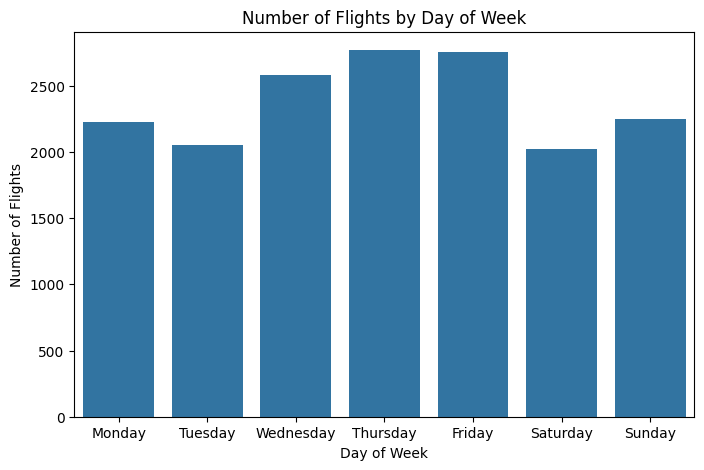

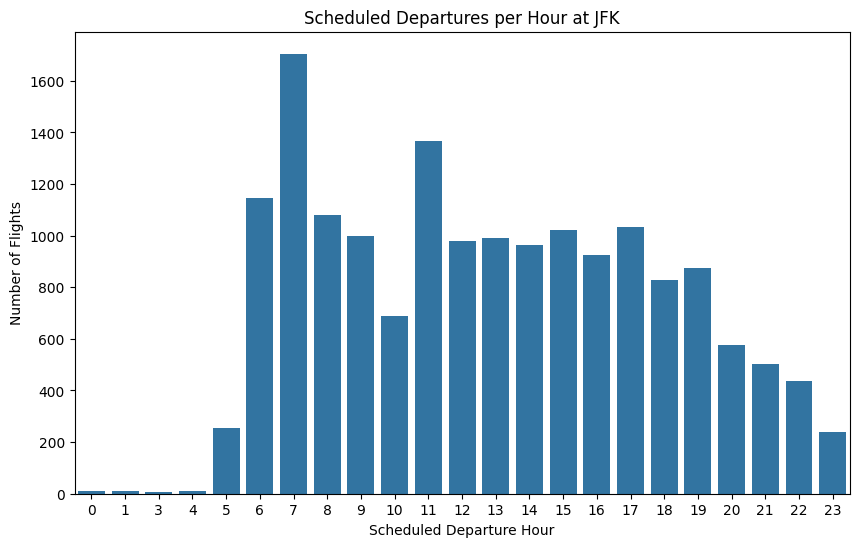

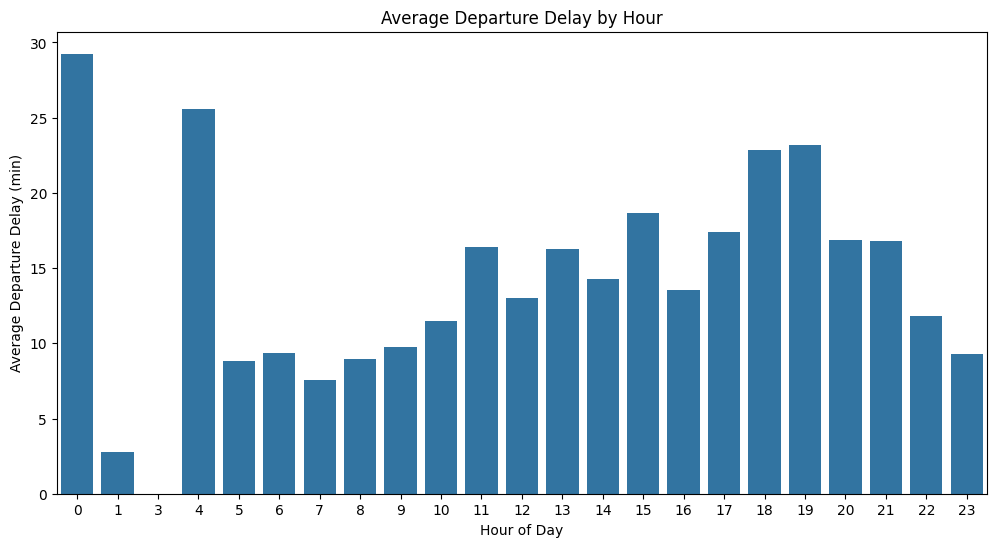

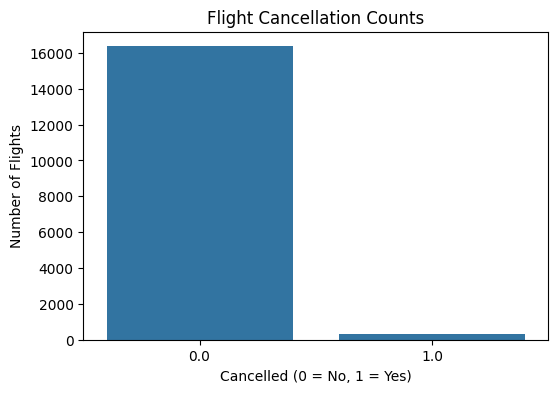

Cancellation rate: 1.77%


/tmp/ipython-input-76437560.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_delays.index, y=mean_delays.values, palette='magma')


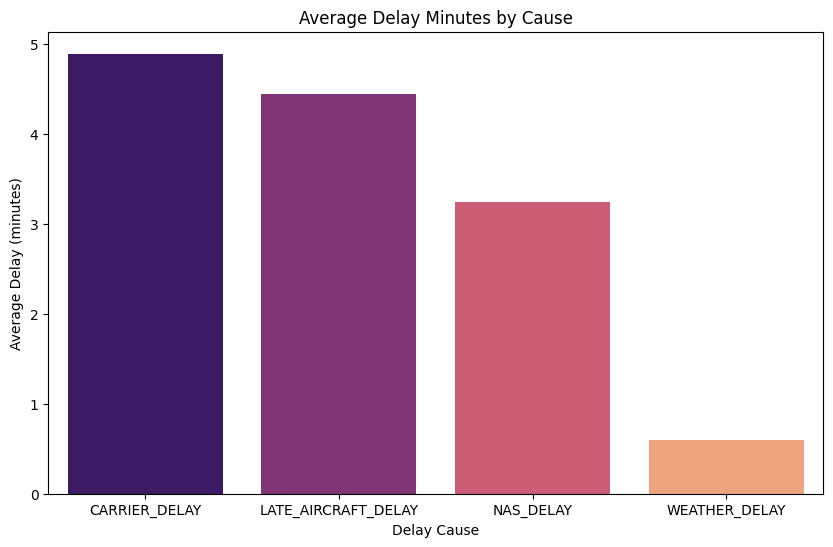

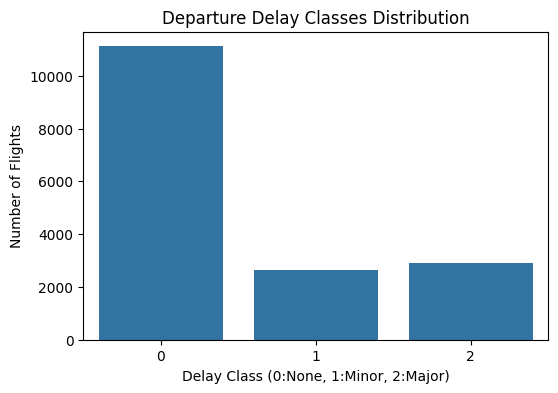

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed cleaned data if saved as parquet, else load CSV and preprocess as needed
df = pd.read_parquet('jfk_flights_clean.parquet')

# Basic Data Overview
print("Data shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum()[lambda x: x > 0])

# Summary statistics for delay columns
delay_cols = ['DEP_DELAY', 'DEP_DELAY_NEW', 'ARR_DELAY', 'ARR_DELAY_NEW',
              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']
print("\nDelay columns summary statistics:")
print(df[delay_cols].describe())

# Flight counts by day of week
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='DAY_OF_WEEK', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Number of Flights by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.show()

# Scheduled Departures distribution by Hour
plt.figure(figsize=(10,6))
sns.countplot(x='DEP_HOUR', data=df)
plt.title('Scheduled Departures per Hour at JFK')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Number of Flights')
plt.show()

# Average Departure Delay per Hour
plt.figure(figsize=(12,6))
avg_dep_delay = df.groupby('DEP_HOUR')['DEP_DELAY_NEW'].mean().reset_index()
sns.barplot(x='DEP_HOUR', y='DEP_DELAY_NEW', data=avg_dep_delay)
plt.title('Average Departure Delay by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Departure Delay (min)')
plt.show()

# Cancellation Counts
plt.figure(figsize=(6,4))
sns.countplot(x='CANCELLED', data=df)
plt.title('Flight Cancellation Counts')
plt.xlabel('Cancelled (0 = No, 1 = Yes)')
plt.ylabel('Number of Flights')
plt.show()
print("Cancellation rate: {:.2f}%".format(df['CANCELLED'].mean() * 100))

# Delay Cause Proportions (Mean Delay Minutes)
plt.figure(figsize=(10,6))
mean_delays = df[delay_cols[4:]].mean().sort_values(ascending=False)
sns.barplot(x=mean_delays.index, y=mean_delays.values, palette='magma')
plt.title('Average Delay Minutes by Cause')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Delay Cause')
plt.show()

# Departure delay classes count
if 'DEP_DELAY_CLASS' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='DEP_DELAY_CLASS', data=df)
    plt.title('Departure Delay Classes Distribution')
    plt.xlabel('Delay Class (0:None, 1:Minor, 2:Major)')
    plt.ylabel('Number of Flights')
    plt.show()


In [17]:
# Total missing values per column
missing_counts = df_clean_complete.isnull().sum()

# Percentage of missing values per column
missing_percent = (missing_counts / len(df_jfk_clean)) * 100

# Combine counts and percentages into a DataFrame and filter columns with any missing data
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percent': missing_percent
}).loc[missing_counts > 0]

print("Complete Missing Values Summary:\n")
print(missing_summary)


Complete Missing Values Summary:

           Missing_Count  Missing_Percent
ARR_DEL15             30         0.180159


In [18]:
df_clean_complete.to_csv('jfk_flights_clean.csv', index=False)


In [19]:
from google.colab import files
files.download('jfk_flights_clean.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>